# Part A: Deep Convolutional Neural Network

This project serves as assingment 2 of CZ4042 Neural Network (Nanyang Technological University).

This part of the assignment aims to give you exposure to the use of convolutional neural networks (CNN) for object recognition in images.

The project uses hand-written digit images provided by the MNIST database.
Use only a subset of MNIST data for training and testing and select first 12,000 images from MNIST train data as training dataset and first 2000 of MNIST test data as testing dataset.



## Initialization
To understand the code better, the Convolutional Neural network will be implemented as a class. It give us flexibility in trying different configuration for the network.

### Import

Additional library used for the experiment.

In [79]:
import pickle
import math

import theano
import theano.tensor as T
from theano.tensor.signal import pool
import numpy as np

import matplotlib.pyplot as plt

np.random.seed(117)

### CNN Softmax Class

- Flexible layer initialization
- SGD learning (with and without momentum)
- RMSProp learning
- ReLu activation function
- Softmax output

In [80]:
""" Convolutional Neural Network with Softmax output function """

class SoftmaxCNN:
    """ Softmax CNN Class """

    def __init__(self):
        self.conv_layers=[]
        self.pool_layers=[]
        self.hidden_layers=[]
        
        self.predictions = []
        self.costs = []
        
        self.train = None
        self.predict = None
        self.test = None
        
        self.learning = None
        self.learning_rate = None
        self.decay = None

        # For SGD learning
        self.momentum = None

        # For RMSProp
        self.rho = None
        self.epsilon = None


    def init_learning_sgd(self, learning_rate=0.05, decay=0.0001, momentum=0.0):
        """ Initialise parameter for SGD learning """
        self.learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        
        self.learning = self.sgd
        if momentum > 0.0:
            self.learning = self.sgd_momentum


    def init_learning_RMSProp(self, learning_rate=0.001, decay=0.0001, rho=0.9, epsilon=1e-6):
        """ Initialise parameter for RMSProp learning """
        self.learning_rate = learning_rate
        self.decay = decay
        self.rho = rho
        self.epsilon = epsilon

        self.learning = self.RMSprop


    def create_model(self, convolutional_layer, pooling_layer, hidden_layer, num_output):
        """
        :param convolutional_layer: list of convolutional [(15,1,9,9), (20,1,5,5)] -> first conv 15 kernels
                                    with size 9x9
        :param pooling_layer: list of ppoling layer [(2,2), (2,2)] -> first pool downsizing the cinv by 4x4
                                Notes that the the length of conv and pool layer need to be same
        :param hidden_layer: List of normal full connected layer [100]
        """

        x = T.tensor4('x')
        d = T.matrix('d')

        weights_conv = []
        biases_conv = []

        # size conv and pool is strictly same
        size_conv_pool = len(convolutional_layer)

        prev_output = x

        """
            Construct the Convolutional together with the Pooling Layer
        """

        for i in range(0, size_conv_pool, 1):
            weight_conv, bias_conv = init_weight_biases_4dimension(
                convolutional_layer[i], x.dtype)

            conv_out = T.nnet.relu(T.nnet.conv2d(prev_output, weight_conv) + bias_conv.dimshuffle('x', 0, 'x', 'x'))
            prev_output = pool.pool_2d(conv_out, pooling_layer[i])

            weights_conv.append(weight_conv)
            biases_conv.append(bias_conv)
            self.conv_layers.append(conv_out)
            self.pool_layers.append(prev_output)

        """
            Construct the full connected layer
        """
        prev_output = T.flatten(prev_output, outdim=2)

        weights = []
        biases = []

        for i in range(0, len(hidden_layer), 1):

            weight, bias = init_weight_biases_2dimensions(hidden_layer[i], x.dtype)

            prev_output = T.nnet.relu(T.dot(prev_output, weight) + bias)

            weights.append(weight)
            biases.append(bias)
            self.hidden_layers.append(prev_output)

        weight, bias = init_weight_biases_2dimensions((hidden_layer[-1][1], num_output), x.dtype)

        weights.append(weight)
        biases.append(bias)

        prev_output = T.nnet.softmax(T.dot(prev_output, weight) + bias)

        prediction = T.argmax(prev_output, axis=1)

        cost = T.mean(T.nnet.categorical_crossentropy(prev_output, d))
        params = weights_conv + biases_conv + weights + biases

        updates = self.learning(cost, params)

        outputs = [cost] + self.conv_layers + self.pool_layers + self.hidden_layers
        
        self.train = theano.function(inputs=[x, d], outputs=outputs, updates=updates, allow_input_downcast=True)
        self.predict = theano.function(inputs=[x], outputs=prediction, allow_input_downcast=True)
        self.test = theano.function(inputs=[x], outputs=outputs[1:], allow_input_downcast=True)


    def sgd(self, cost, params):
        """ Learning using SGD """
        grads = T.grad(cost=cost, wrt=params)
        updates = []
        for p, g in zip(params, grads):
            updates.append([p, p - (g + self.decay * p) * self.learning_rate])
        return updates


    def sgd_momentum(self, cost, params):
        """ Learning using SGD with momentum """
        grads = T.grad(cost=cost, wrt=params)
        updates = []
        for p, g in zip(params, grads):
            v = theano.shared(p.get_value()*0.)
            v_new = self.momentum*v - (g + self.decay*p) * self.learning_rate
            updates.append([p, p + v_new])
            updates.append([v, v_new])
        
        return updates


    def RMSprop(self, cost, params):
        """ Learning using RMSProp """
        grads = T.grad(cost=cost, wrt=params)
        updates = []
        for p, g in zip(params, grads):
            acc = theano.shared(p.get_value() * 0.)
            acc_new = self.rho * acc + (1 - self.rho) * g ** 2
            gradient_scaling = T.sqrt(acc_new + self.epsilon)
            g = g / gradient_scaling
            updates.append((acc, acc_new))
            updates.append((p, p - self.learning_rate * (g+ self.decay*p)))
        return updates


    def start_train(self, tr_x, tr_y, te_x, te_y, epochs, batch_size):
        """ Start training based on initialized model """

        for i in range(epochs):

            tr_x, tr_y = shuffle_data(tr_x, tr_y)
            te_x, te_y = shuffle_data(te_x, te_y)

            costs = []

            for start, end in zip(range(0, len(tr_x), batch_size), range(batch_size, len(tr_y), batch_size)):
                outputs = self.train(tr_x[start:end], tr_y[start:end])
                costs.append(outputs[0])

            self.predictions.append(np.mean(np.argmax(te_y, axis=1) == self.predict(te_x)))
            self.costs.append(np.mean(costs))

            print('epoch: %d, accuracy: %s, cost: %s \n' % (i+1, self.predictions[i], self.costs[i]))
        
        return self.predictions, self.costs
    
    def get_prediction_cost(self):
        return self.predictions, self.costs

### Data Colector

Helper to get the train and test data from mnist.pkl

In [81]:
""" 
Data collector for mnist.pkl 
"""

class DataCollector:
    """ DataCollector class """

    def __init__(self, file_path):
        with open(file_path, "rb") as input_file:
            self.data = pickle.load(input_file)

        self.data_train = self.data[0]
        self.data_test = self.data[2]
        self.data_validate = self.data[1]

    def get_train_data(self):
        """ get train data with one hot encoding """
        return self.data_train[0], self.return_one_hot_encoding(10, self.data_train[1])

    def get_test_data(self):
        """ get test data with one hot encoding """
        return self.data_test[0], self.return_one_hot_encoding(10, self.data_test[1])

    def get_validation_data(self):
        """ get validation data with one hot encoding """
        return self.data_validate[0], self.return_one_hot_encoding(10, self.data_validate[1])

    def return_one_hot_encoding(self, num_output, list_data):
        """ One hot encoding """
        zeros = np.zeros((len(list_data), num_output))

        for i in range(len(zeros)):
            zeros[i][list_data[i]] = 1

        return zeros


### Data Visualization

Visualize the data as graphs or image

In [82]:
""" Data Visualization for CNN Softmax """

class DataVisualization:
    """
    Data Visualizer
    - Graph visualizer
    - Image visualizer
    """ 

    def __init__(self):
       return

    def plot_graphs(self, list_x_point, list_y_point, x_label, y_label, title, figure_name="", show_image=True):
        """ Plot graphs from data"""
        plt.figure()
        plt.plot(list_x_point, list_y_point)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        
        if figure_name != "":
            plt.savefig(figure_name)
        
        if show_image:
            plt.show()
    
    def show_plot(self, list_x_point, list_y_point, x_label, y_label, title, figure_name, labels):

        plt.figure()

        for cnt in range(len(labels)):
           plt.plot(list_x_point[cnt], list_y_point[cnt], label=labels[cnt])

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.legend()
        plt.savefig(figure_name)
        plt.show()


    def plot_images(self, data, figure_name="", number_column=10, limit_image=20, size=28, transpose=True, show_image=True):
        """ Plot images from data"""
        width = height = size

        plt.figure()
        plt.gray()
        row = limit_image/number_column

        for i in range(1, limit_image+1):
            plt.subplot(row, number_column, i)
            plt.axis('off')
            if transpose:
                norm_image = data[:, i-1].reshape(width, height)
            else:
                norm_image = self.normalize_image(data[i-1].reshape(width, height))
            plt.imshow(norm_image)

        if figure_name != "":
            plt.savefig(figure_name)
        
        if show_image:
            plt.show()


    def normalize_image(self, image):
        """ Normalize image data """
        min_val = np.min(image)
        max_val = np.max(image)

        return (image-min_val)/(max_val-min_val)


### Utility

Additional utility functions used in the experiment

In [83]:
""" Utility function for CNN Softmax
- Weights and biases 4d initialization
- Weights and biases 2d initialization
- Shufle data
"""


def init_weight_biases_4dimension(filter_shape, d_type):
    """ Initialized 4d weights and biases """
    fan_in = np.prod(filter_shape[1:])
    fan_out = filter_shape[0] * np.prod(filter_shape[2:])

    bound = np.sqrt(6. / (fan_in + fan_out))
    w_values = np.asarray(
        np.random.uniform(low=-bound, high=bound, size=filter_shape),
        dtype=d_type)
    b_values = np.zeros((filter_shape[0],), dtype=d_type)
    return theano.shared(w_values, borrow=True), theano.shared(b_values, borrow=True)


def init_weight_biases_2dimensions(filter_shape, d_type):
    """ Initialized 2d weights and biases """
    fan_in = filter_shape[1]
    fan_out = filter_shape[0]

    bound = np.sqrt(6. / (fan_in + fan_out))
    w_values = np.asarray(
        np.random.uniform(low=-bound, high=bound, size=filter_shape),
        dtype=d_type)
    b_values = np.zeros((filter_shape[1],), dtype=d_type)
    return theano.shared(w_values, borrow=True), theano.shared(b_values, borrow=True)


def shuffle_data(samples, labels):
    """ Shuffle data """
    idx = np.arange(samples.shape[0])
    np.random.shuffle(idx)
    samples, labels = samples[idx], labels[idx]
    return samples, labels


## Question 1
To recognize MNIST digits, design a convolutional neural network consisting of

- An Input layer of 28x28 dimensions
- A convolution layer C1 of 15 feature maps and filters of window size 9x9. A max pooling layer S1 with a pooling window of size 2x2.
- A convolution layer C2 of 20 feature maps and filters of window size 5x5. A max pooling layer S2 with a pooling window of size 2x2.
- A fully connected layer F3 of size 100.
- A softmax layer F4 of size 10.

Train the network using ReLu activation functions for neurons and mini batch gradient descent learning. Set batch size 128, learning rate (alpha) = 0.05 and decay parameter (beta) = 10−4. 

- Plot the training cost and test accuracy with learning epochs.
- For two representative test patterns, plot the feature maps at the convolution and pooling layers.

Start question 1!


/Users/edwardsujono/Python_Project/assignment_neural_network_2/ENV/lib/python2.7/site-packages/ipykernel_launcher.py:80: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use cuDNN. When using ignore_border=False and not using cuDNN, the only GPU combination supported is when `ws == stride and pad == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.


epoch: 1, accuracy: 0.766, cost: 1.5747707825 

epoch: 2, accuracy: 0.8655, cost: 0.487393412869 

epoch: 3, accuracy: 0.8945, cost: 0.288994526765 

epoch: 4, accuracy: 0.9215, cost: 0.220469097225 

epoch: 5, accuracy: 0.9145, cost: 0.181318805584 

epoch: 6, accuracy: 0.9405, cost: 0.150421925858 

epoch: 7, accuracy: 0.943, cost: 0.133973805695 

epoch: 8, accuracy: 0.9425, cost: 0.120183076065 

epoch: 9, accuracy: 0.95, cost: 0.107808559947 

epoch: 10, accuracy: 0.9425, cost: 0.0995119888243 

epoch: 11, accuracy: 0.9445, cost: 0.090277631348 

epoch: 12, accuracy: 0.945, cost: 0.0833881930747 

epoch: 13, accuracy: 0.9495, cost: 0.0776840041127 

epoch: 14, accuracy: 0.953, cost: 0.073065558382 

epoch: 15, accuracy: 0.9515, cost: 0.0694923318636 

epoch: 16, accuracy: 0.9545, cost: 0.0631293904551 

epoch: 17, accuracy: 0.9555, cost: 0.0612647058616 

epoch: 18, accuracy: 0.9585, cost: 0.0570494576773 

epoch: 19, accuracy: 0.958, cost: 0.053256125411 

epoch: 20, accuracy: 0.

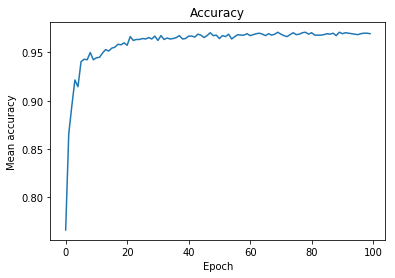

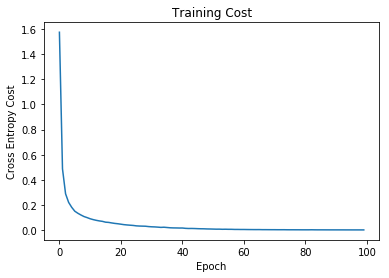

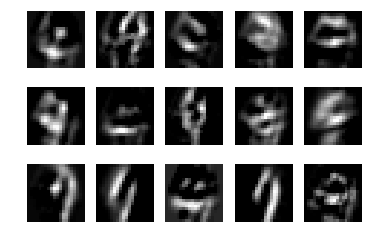

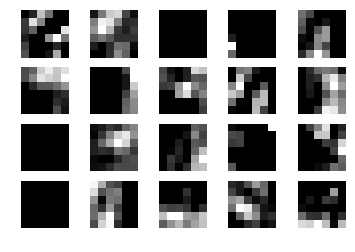

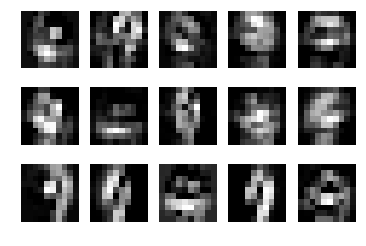

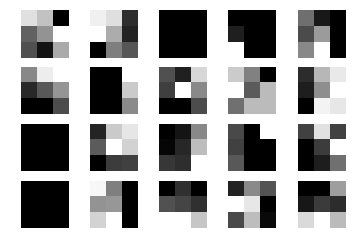

Finished question 1


In [87]:
""" 
Start script question 1
""" 

# import numpy as np
# from project_a.cnn_softmax import SoftmaxCNN
# from project_a.data_collector import DataCollector
# from project_a.data_visualization import DataVisualization


""" question 1 """
print("Start question 1!")
np.random.seed(10)

batch_size = 128
epoch = 100

learning_rate = 0.05
decay = 0.0001

data_collector = DataCollector("../mnist.pkl")
graph_visualizer = DataVisualization()

trX, trY = data_collector.get_train_data()
teX, teY = data_collector.get_test_data()

trX = trX.reshape(-1, 1, 28, 28)
teX = teX.reshape(-1, 1, 28, 28)

trX, trY = trX[:12000], trY[:12000]
teX, teY = teX[2000:4000], teY[2000:4000]

""" 
Question 1: SGD
"""
cnn = SoftmaxCNN()
cnn.init_learning_sgd(learning_rate, decay)
cnn.create_model(
    convolutional_layer=[(15, 1, 9, 9), (20, 15, 5, 5)],
    pooling_layer=[(2, 2), (2, 2)],
    hidden_layer=[(20*3*3, 100)],
    num_output=10)
accuracy, costs = cnn.start_train(trX, trY, teX, teY, epoch, batch_size)
graph_visualizer.plot_graphs(
    list_x_point=range(epoch),
    list_y_point=accuracy,
    x_label="Epoch",
    y_label="Mean accuracy",
    title="Accuracy",
    figure_name="../data/project_a/Figure1.1-AccuracyEpoch.png",
    show_image=False
)
graph_visualizer.plot_graphs(
    list_x_point=range(epoch),
    list_y_point=costs,
    x_label="Epoch",
    y_label="Cross Entropy Cost",
    title="Training Cost",
    figure_name="../data/project_a/Figure1.2-CostEpoch.png",
    show_image=False
)

ind = np.random.randint(low=0, high=2000)
outputs = cnn.test(teX[ind:ind+1,:])
graph_visualizer.plot_images(
    outputs[0], figure_name="../data/project_a/Figure1b.3.1-ConvLayer1.png", 
    number_column=5, limit_image=15, size=20
)
graph_visualizer.plot_images(
    outputs[1], figure_name="../data/project_a/Figure1b.3.3-ConvLayer2.png", 
    number_column=5, limit_image=20, size=6
)
graph_visualizer.plot_images(
    outputs[2], figure_name="../data/project_a/Figure1b.3.2-PoolLayer1.png", 
    number_column=5, limit_image=15, size=10
)
graph_visualizer.plot_images(
    outputs[3], figure_name="../data/project_a/Figure1b.3.4-PoolLayer2.png", 
    number_column=5, limit_image=20, size=3
)

print("Finished question 1")



## Question 2
Repeat part 1 by adding the momentum term to mini batch gradient descent learning with momentum parameter (gamma) = 0.1.

Start question 2!


/Users/edwardsujono/Python_Project/assignment_neural_network_2/ENV/lib/python2.7/site-packages/ipykernel_launcher.py:80: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use cuDNN. When using ignore_border=False and not using cuDNN, the only GPU combination supported is when `ws == stride and pad == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.


epoch: 1, accuracy: 0.7925, cost: 1.48736545824 

epoch: 2, accuracy: 0.8695, cost: 0.435657852571 

epoch: 3, accuracy: 0.903, cost: 0.269177798966 

epoch: 4, accuracy: 0.9225, cost: 0.205009960331 

epoch: 5, accuracy: 0.921, cost: 0.1698642946 

epoch: 6, accuracy: 0.9435, cost: 0.140747074572 

epoch: 7, accuracy: 0.9455, cost: 0.125225939649 

epoch: 8, accuracy: 0.9445, cost: 0.111772043897 

epoch: 9, accuracy: 0.952, cost: 0.100006515209 

epoch: 10, accuracy: 0.946, cost: 0.091542232894 

epoch: 11, accuracy: 0.9445, cost: 0.0832141681411 

epoch: 12, accuracy: 0.9485, cost: 0.0775202989922 

epoch: 13, accuracy: 0.9495, cost: 0.0724682253544 

epoch: 14, accuracy: 0.954, cost: 0.0673770914362 

epoch: 15, accuracy: 0.954, cost: 0.064116831397 

epoch: 16, accuracy: 0.9575, cost: 0.0578508008257 

epoch: 17, accuracy: 0.9555, cost: 0.0554524428921 

epoch: 18, accuracy: 0.96, cost: 0.0516282175618 

epoch: 19, accuracy: 0.961, cost: 0.048369991353 

epoch: 20, accuracy: 0.965

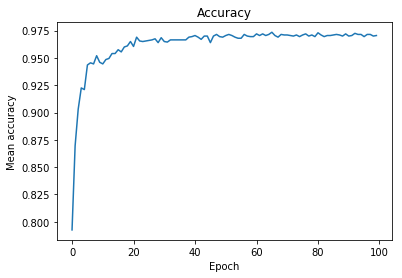

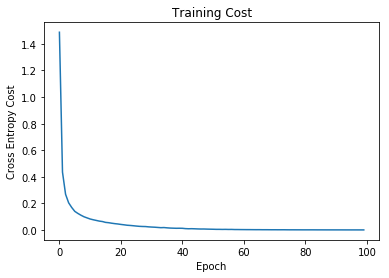

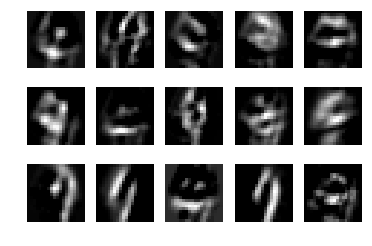

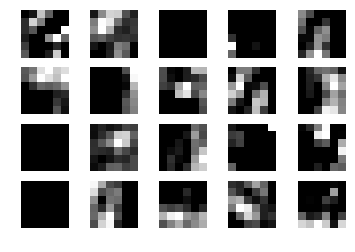

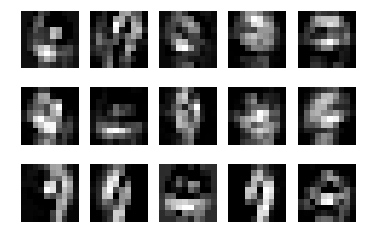

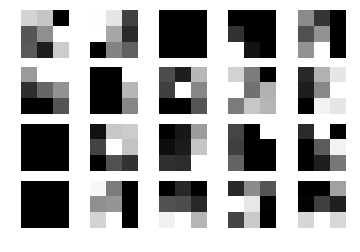

Finished question 2


In [88]:
""" 
Start script question 2
""" 

# import numpy as np
# from project_a.cnn_softmax import SoftmaxCNN
# from project_a.data_collector import DataCollector
# from project_a.data_visualization import DataVisualization


""" question 2 """
print("Start question 2!")
np.random.seed(10)

batch_size = 128
epoch = 100

learning_rate = 0.05
decay = 0.0001
momentum = 0.1

data_collector = DataCollector("../mnist.pkl")
graph_visualizer = DataVisualization()

trX, trY = data_collector.get_train_data()
teX, teY = data_collector.get_test_data()

trX = trX.reshape(-1, 1, 28, 28)
teX = teX.reshape(-1, 1, 28, 28)

trX, trY = trX[:12000], trY[:12000]
teX, teY = teX[2000:4000], teY[2000:4000]

"""
Question 2: SGD with momentum
"""
cnn2 = SoftmaxCNN()
cnn2.init_learning_sgd(learning_rate, decay, momentum)
cnn2.create_model(
    convolutional_layer=[(15, 1, 9, 9), (20, 15, 5, 5)],
    pooling_layer=[(2, 2), (2, 2)],
    hidden_layer=[(20*3*3, 100)],
    num_output=10)
accuracy, costs = cnn2.start_train(trX, trY, teX, teY, epoch, batch_size)
graph_visualizer.plot_graphs(
    list_x_point=range(epoch),
    list_y_point=accuracy,
    x_label="Epoch",
    y_label="Mean accuracy",
    title="Accuracy",
    figure_name="../data/project_a/Figure2.1-AccuracyEpoch.png",
    show_image=False
)
graph_visualizer.plot_graphs(
    list_x_point=range(epoch),
    list_y_point=costs,
    x_label="Epoch",
    y_label="Cross Entropy Cost",
    title="Training Cost",
    figure_name="../data/project_a/Figure2.2-CostEpoch.png",
    show_image=False
)

ind = np.random.randint(low=0, high=2000)
outputs = cnn2.test(teX[ind:ind+1,:])
graph_visualizer.plot_images(
    outputs[0], figure_name="../data/project_a/Figure2b.3.1-ConvLayer1.png", 
    number_column=5, limit_image=15, size=20
)
graph_visualizer.plot_images(
    outputs[1], figure_name="../data/project_a/Figure2b.3.3-ConvLayer2.png", 
    number_column=5, limit_image=20, size=6
)
graph_visualizer.plot_images(
    outputs[2], figure_name="../data/project_a/Figure2b.3.2-PoolLayer1.png", 
    number_column=5, limit_image=15, size=10
)
graph_visualizer.plot_images(
    outputs[3], figure_name="../data/project_a/Figure2b.3.4-PoolLayer2.png", 
    number_column=5, limit_image=20, size=3
)


print("Finished question 2")



## Question 3
Repeat part 1 by using RMSProp algorithm for learning. Use learning rate = 0.001, decay = 0.0001 , rho = 0.9,
and epsilon = 0.000001 for RMSProp.

Start question 3!


/Users/edwardsujono/Python_Project/assignment_neural_network_2/ENV/lib/python2.7/site-packages/ipykernel_launcher.py:80: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use cuDNN. When using ignore_border=False and not using cuDNN, the only GPU combination supported is when `ws == stride and pad == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.


epoch: 1, accuracy: 0.8575, cost: 0.871979664314 

epoch: 2, accuracy: 0.8965, cost: 0.300182952681 

epoch: 3, accuracy: 0.9335, cost: 0.201126679176 

epoch: 4, accuracy: 0.9335, cost: 0.14491332647 

epoch: 5, accuracy: 0.938, cost: 0.116556950986 

epoch: 6, accuracy: 0.954, cost: 0.0945720914167 

epoch: 7, accuracy: 0.956, cost: 0.0791304440296 

epoch: 8, accuracy: 0.963, cost: 0.0685539187125 

epoch: 9, accuracy: 0.9585, cost: 0.0607840081578 

epoch: 10, accuracy: 0.9485, cost: 0.0528425082991 

epoch: 11, accuracy: 0.9535, cost: 0.0457945372767 

epoch: 12, accuracy: 0.9625, cost: 0.0412725601717 

epoch: 13, accuracy: 0.9645, cost: 0.0360107369225 

epoch: 14, accuracy: 0.9645, cost: 0.0321705275646 

epoch: 15, accuracy: 0.9645, cost: 0.0281665457365 

epoch: 16, accuracy: 0.9585, cost: 0.0237753704187 

epoch: 17, accuracy: 0.97, cost: 0.0220306305031 

epoch: 18, accuracy: 0.9665, cost: 0.0178088935738 

epoch: 19, accuracy: 0.969, cost: 0.0155628064605 

epoch: 20, accu

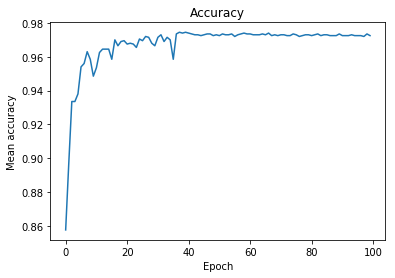

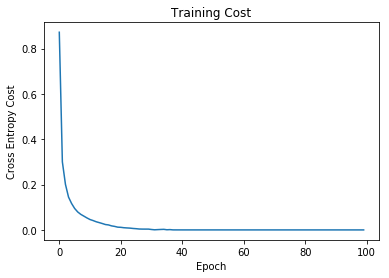

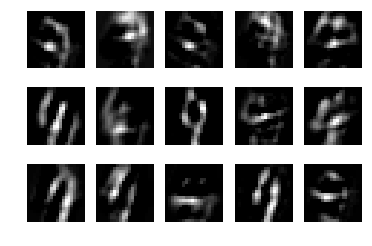

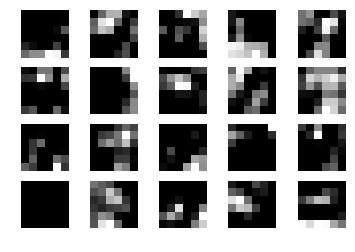

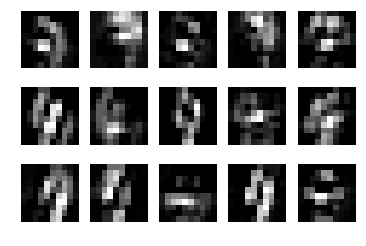

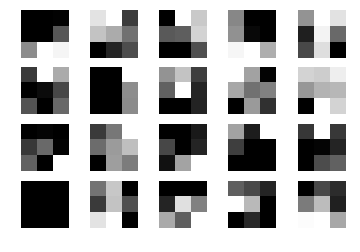

Finished question 3


In [89]:
""" 
Start script question 3
""" 

# import numpy as np
# from project_a.cnn_softmax import SoftmaxCNN
# from project_a.data_collector import DataCollector
# from project_a.data_visualization import DataVisualization


""" question 3 """
print("Start question 3!")
np.random.seed(10)

batch_size = 128
epoch = 100

learning_rate = 0.001
decay = 0.0001
rho = 0.9
epsilon = 1e-6

data_collector = DataCollector("../mnist.pkl")
graph_visualizer = DataVisualization()

trX, trY = data_collector.get_train_data()
teX, teY = data_collector.get_test_data()

trX = trX.reshape(-1, 1, 28, 28)
teX = teX.reshape(-1, 1, 28, 28)

trX, trY = trX[:12000], trY[:12000]
teX, teY = teX[2000:4000], teY[2000:4000]

"""
Question 3: RPMS Prop
"""
cnn3 = SoftmaxCNN()
cnn3.init_learning_RMSProp(learning_rate, decay, rho, epsilon)
cnn3.create_model(
    convolutional_layer=[(15, 1, 9, 9), (20, 15, 5, 5)],
    pooling_layer=[(2, 2), (2, 2)],
    hidden_layer=[(20*3*3, 100)],
    num_output=10)
accuracy, costs = cnn3.start_train(trX, trY, teX, teY, epoch, batch_size)
graph_visualizer.plot_graphs(
    list_x_point=range(epoch),
    list_y_point=accuracy,
    x_label="Epoch",
    y_label="Mean accuracy",
    title="Accuracy",
    figure_name="../data/project_a/Figure3.1-AccuracyEpoch.png",
    show_image=False
)
graph_visualizer.plot_graphs(
    list_x_point=range(epoch),
    list_y_point=costs,
    x_label="Epoch",
    y_label="Cross Entropy Cost",
    title="Training Cost",
    figure_name="../data/project_a/Figure3.2-CostEpoch.png",
    show_image=False
)

ind = np.random.randint(low=0, high=2000)
outputs = cnn3.test(teX[ind:ind+1,:])
graph_visualizer.plot_images(
    outputs[0], figure_name="../data/project_a/Figure3b.3.1-ConvLayer1.png", 
    number_column=5, limit_image=15, size=20
)
graph_visualizer.plot_images(
    outputs[1], figure_name="../data/project_a/Figure3b.3.3-ConvLayer2.png", 
    number_column=5, limit_image=20, size=6
)
graph_visualizer.plot_images(
    outputs[2], figure_name="../data/project_a/Figure3b.3.2-PoolLayer1.png", 
    number_column=5, limit_image=15, size=10
)
graph_visualizer.plot_images(
    outputs[3], figure_name="../data/project_a/Figure3b.3.4-PoolLayer2.png", 
    number_column=5, limit_image=20, size=3
)


print("Finished question 3")



### Comparison
Compare the result (Cost and Accuracy) from 3 part of the experiment

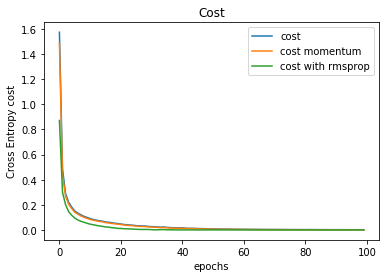

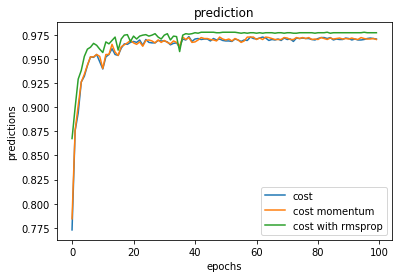

In [70]:
graph_visualizer = DataVisualization()
epochs = 100
cost1 = cnn.get_prediction_cost()[1]
cost2 = cnn2.get_prediction_cost()[1]
cost3 = cnn3.get_prediction_cost()[1]

prediction1 = cnn.get_prediction_cost()[0]
prediction2 = cnn2.get_prediction_cost()[0]
prediction3 = cnn3.get_prediction_cost()[0]

graph_visualizer.show_plot(list_x_point=[range(epochs) for k in range(3)],
                     list_y_point=[cost1, cost2, cost3],
                     x_label='epochs',
                     y_label='Cross Entropy cost',
                     title='Cost' ,
                     figure_name='../data/project_a/comparison_cost.png',
                     labels=['cost', 'cost momentum', 'cost with rmsprop']  
                    )

graph_visualizer.show_plot(list_x_point=[range(epochs) for k in range(3)],
                     list_y_point=[prediction1, prediction2, prediction3],
                     x_label='epochs',
                     y_label='predictions',
                     title='prediction' ,
                     figure_name='../data/project_a/comparison_prediction.png',
                     labels=['cost', 'cost momentum', 'cost with rmsprop']  
                    )